In [5]:
%%capture
!pip install s3fs
!pip install -U kaleido

In [85]:
import pandas as pd
import boto3
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import plotly.express as px
from collections import Counter
import os
pd.set_option('display.max_columns', None)

## Helper Functions

In [92]:
def plot_tone(df_all, save_dir, time_period = "Daily", location_name = "Taj Mahal", avg_type = None):
#     plt.show()
    
    try: os.mkdir(f"{save_dir}/{time_period}")
    except: print(f"{save_dir}/{time_period} already exists.")
    plt.figure(figsize=(20,6))
    print("PLOT: Period: {}, Location: {}, AvgType: {}".format(time_period, location_name, avg_type))
    if not avg_type:
        sns.lineplot(x = "date", y = "AverageSentiment",data=df_all, label = "Average Sentiment")
        sns.lineplot(x = "date", y = "zero",data=df_all, color = 'black')
        sns.set(style='dark')
        plt.xlabel("Date")
        plt.ylabel("Tone")
        title = f"{time_period} Average Sentiment, 2015-2022 - {location_name}"
        
            
        plt.title(title, fontsize=16)
        location_name = location_name.replace(" ","_")
        
        if save_dir:
            plt.savefig(f"{save_dir}/{time_period}/{location_name}_{time_period}.png", dpi = 500)
        
            
    elif avg_type == "rolling":
        print("Rolling plotted")
        df_all['tone_rolling_avg'] = df_all['AverageSentiment'].rolling(7,1).mean()
        sns.lineplot(x = "date", y = "tone_rolling_avg",data=df_all, label = "Average Sentiment")
        sns.lineplot(x = "date", y = "zero",data=df_all, color = 'black')
        sns.set(style='dark')
        plt.xlabel("Date")
        plt.ylabel("Tone")
        title = f"{time_period} Moving Average Sentiment, 2015-2022 - {location_name}"
        plt.title(title, fontsize = 16)
        location_name = location_name.replace(" ","")
        
        if save_dir:
            plt.savefig(f"{save_dir}/{time_period}/{location_name}_RollingAverage_{time_period}.png", dpi = 500)
        
    else:
        raise ValueError("Unknow avg type:"+avg_type + ", Expected None or 'rolling'.")
        
    plt.show()
    
    
# def plot_tone_plotly(df_all, save_dir, time_period = "Daily",  grid = 168997, location_name = "Taj Mahal", avg_type = None, theme_type = None ):
    
#     if not avg_type:
#         fig = px.line(df_all, x='date', y="tone_avg")
#         if not theme_type:
#             title = f"{time_period} Average Tone, 2015-2022 - {location_name} - Prio Grid {grid}"
#         elif theme_type == "hindu":
#             title = f"{time_period} Average Tone - Hindu themes, 2015-2022 - {location_name} - Prio Grid {grid}"
#         elif theme_type == "muslim":
#             title = f"{time_period} Average Tone - Muslim themes, 2015-2022 - {location_name} - Prio Grid {grid}"
#         else:
#             raise ValueError("Incorrect theme type detected. Expected None, 'hindu' or 'muslim'.")
#         fig.update_layout(
#             title=title,
#             xaxis_title="Date",
#             yaxis_title="Tone")
#         if not theme_type:
#             fig.write_image(f"{save_dir}/Tone_{grid}_{time_period}.png", width = 1500)
#         else:
#             fig.write_image(f"{save_dir}/Tone_{theme_type}_{grid}_{time_period}.png") 
            
#     elif avg_type == "rolling":
#         df_all['tone_rolling_avg'] = df_all['tone_avg'].rolling(7,1).mean()
#         fig = px.line(df_all, x='date', y="tone_rolling_avg")
#         if not theme_type:
#             title = f"{time_period} - Rolling Average Tone, 2015-2022 - {location_name} - Prio Grid {grid}"
#         elif theme_type == "hindu":
#             title = f"{time_period} - Rolling Average Tone - Hindu themes, 2015-2022 - {location_name} - Prio Grid {grid}"
#         elif theme_type == "muslim":
#             title = f"{time_period} - Rolling Average Tone - Muslim themes, 2015-2022 - {location_name} - Prio Grid {grid}"
#         else:
#             raise ValueError("Incorrect theme type detected. Expected None, 'hindu' or 'muslim'.")
#         fig.update_layout(
#             title=title,
#             xaxis_title="Date",
#             yaxis_title="Tone")
        
#         if not theme_type:
#             fig.write_image(f"{save_dir}/Tone_{grid}_RollingAverage_{time_period}.png")
#         else:
#             fig.write_image(f"{save_dir}/Tone_{theme_type}_{grid}_RollingAverage_{time_period}.png") 
            
        
#     else:
#         raise ValueError("Unknow avg type:"+avg_type + ", Expected None or 'rolling'.")
        
#     fig.show()

# Reading Data

In [88]:
# Helper Functions
def replace_zero_with_null(x):
    if x == 0:
        return None
    else:
        return x
    
#To plot the average sentiment as a line graph and nato sentiment as scatter plot
def plot_nato_tone(country_mapping, country, df_tone, save_dir = "NATO_tone"):
    title = f"Monthly Average Tone (2015 - Present), {country_mapping[country]}"
    plt.figure(figsize=(20,6))
    df_tone['zero'] = 0
    sns.lineplot(x = "date", y = "AverageSentiment",data=df_tone, label = "Average Sentiment")
    sns.lineplot(x = "date", y = "zero",data=df_tone, color = 'black')
    sns.scatterplot(x = "date", y = "AverageSentiment_Nato_Mod", data=df_tone, marker = 'o', s = 100, color = 'orange', label = "NATO Sentiment")
    sns.set(style='dark')
    plt.xlabel("Date")
    plt.ylabel("Tone")
    plt.title(title, fontsize=16)
    plt.savefig(f"{save_dir}/Tone_NATO_{country}.png", dpi = 500)
    plt.show()


In [89]:
country_prio_map = {('PE', 'Peru'): [109657,
                                      110375,
                                      115406,
                                      116126,
                                      117562,
                                      111817,
                                      111806,
                                      118286,
                                      108210,
                                      106057,
                                      113965,
                                      115404],
 ('PE', 'Cuzco'): [109657],
 ('PE', 'Lima'): [111806],
 ('PE', 'Chan Chan'): [117562],
 ('CI', 'Chile'): [90142, 81577, 67893, 100301, 80140, 103180, 103181],
 ('CI', 'Rapa Nui'): [90142]}

Task#24_PeruChile already exists.
Time Period: Daily, Location:Peru
Task#24_PeruChile/Daily already exists.
PLOT: Period: Daily, Location: Peru, AvgType: rolling
Rolling plotted


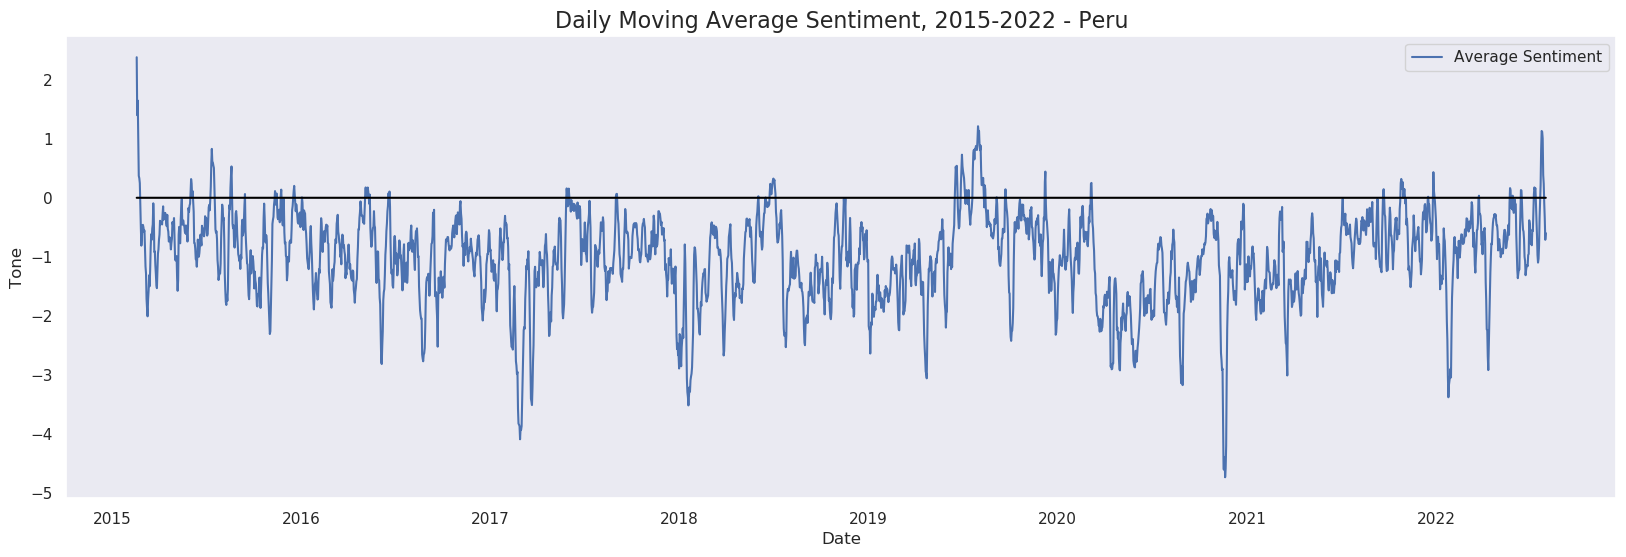

Time Period: Daily, Location:Cuzco
Task#24_PeruChile/Daily already exists.
PLOT: Period: Daily, Location: Cuzco, AvgType: rolling
Rolling plotted


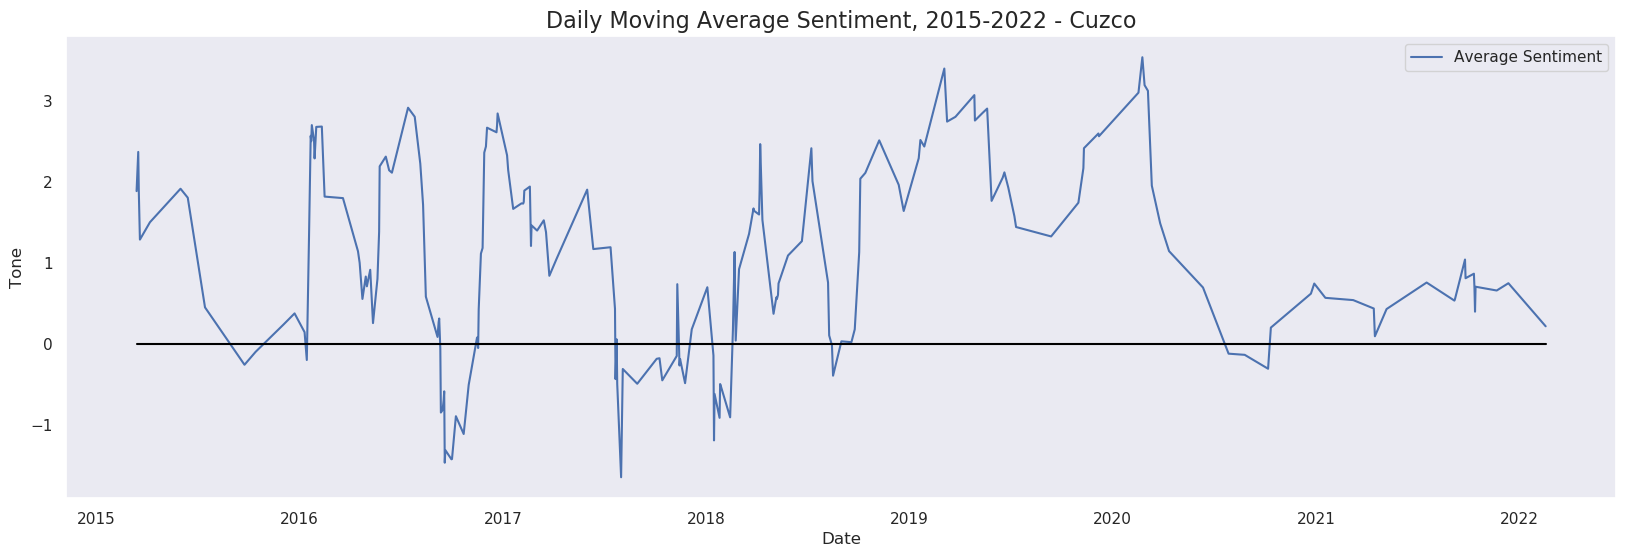

Time Period: Daily, Location:Lima
Task#24_PeruChile/Daily already exists.
PLOT: Period: Daily, Location: Lima, AvgType: rolling
Rolling plotted


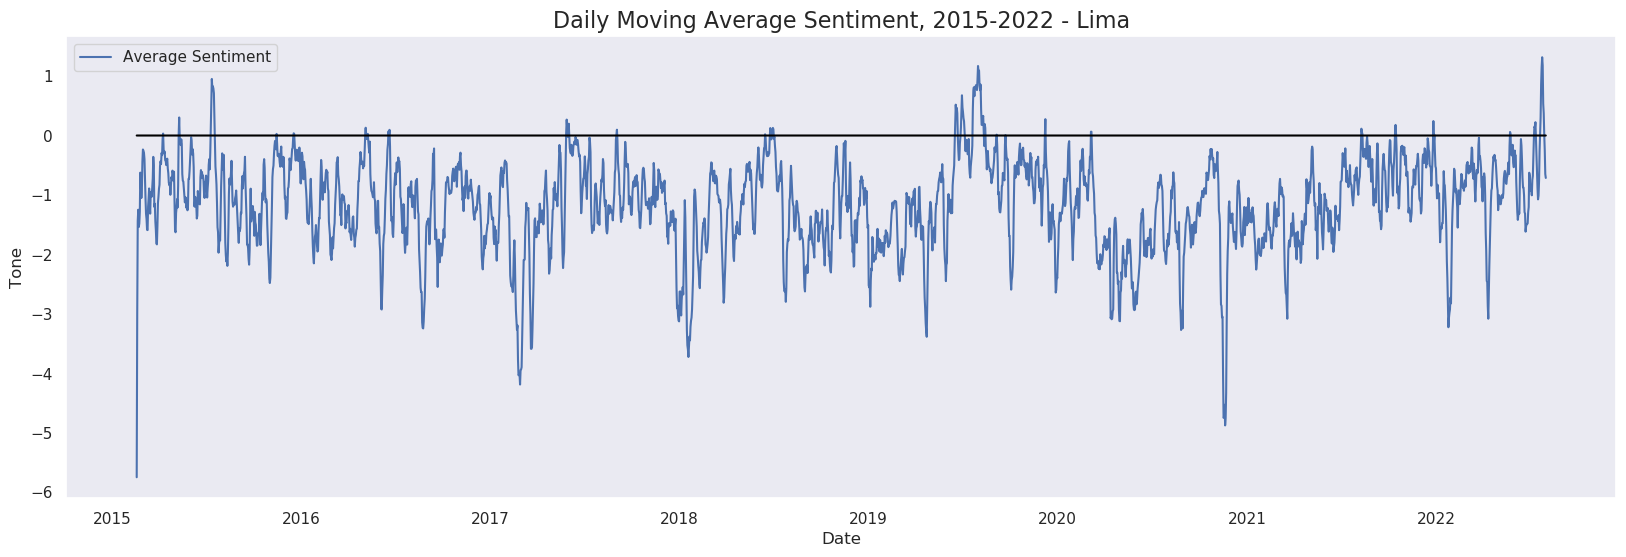

Time Period: Daily, Location:Chan Chan
Task#24_PeruChile/Daily already exists.
PLOT: Period: Daily, Location: Chan Chan, AvgType: rolling
Rolling plotted


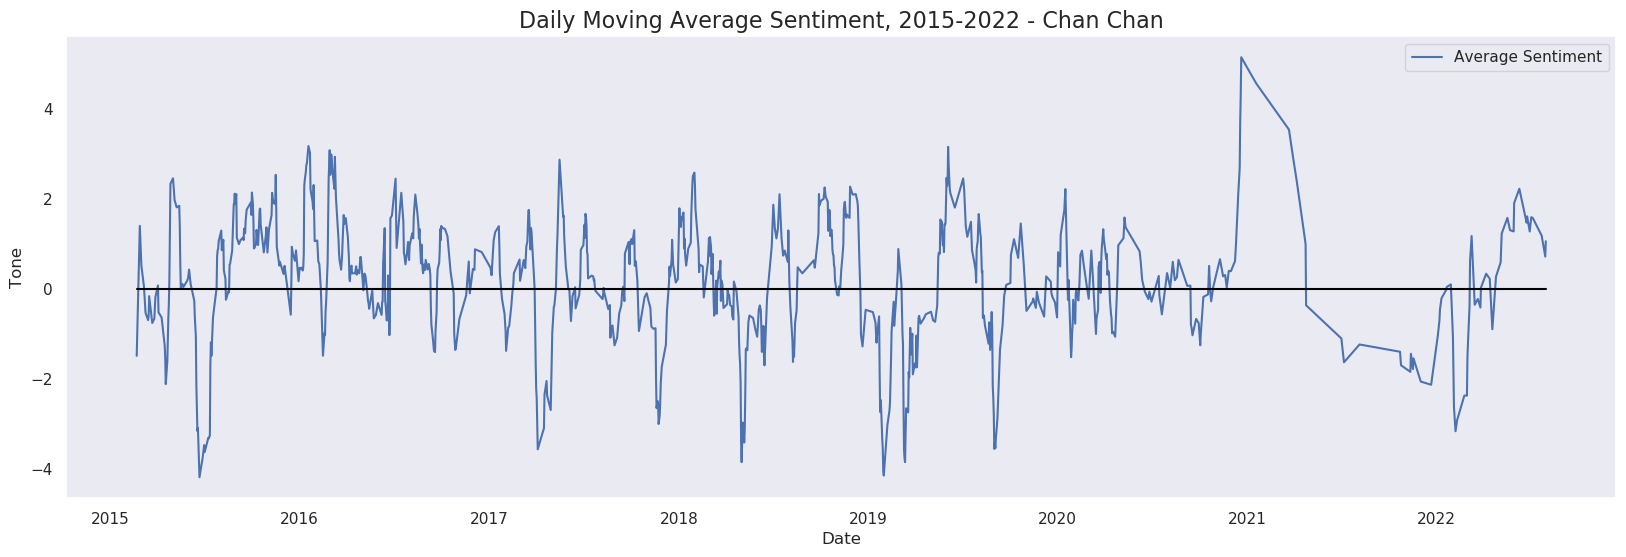

Time Period: Daily, Location:Chile
Task#24_PeruChile/Daily already exists.
PLOT: Period: Daily, Location: Chile, AvgType: rolling
Rolling plotted


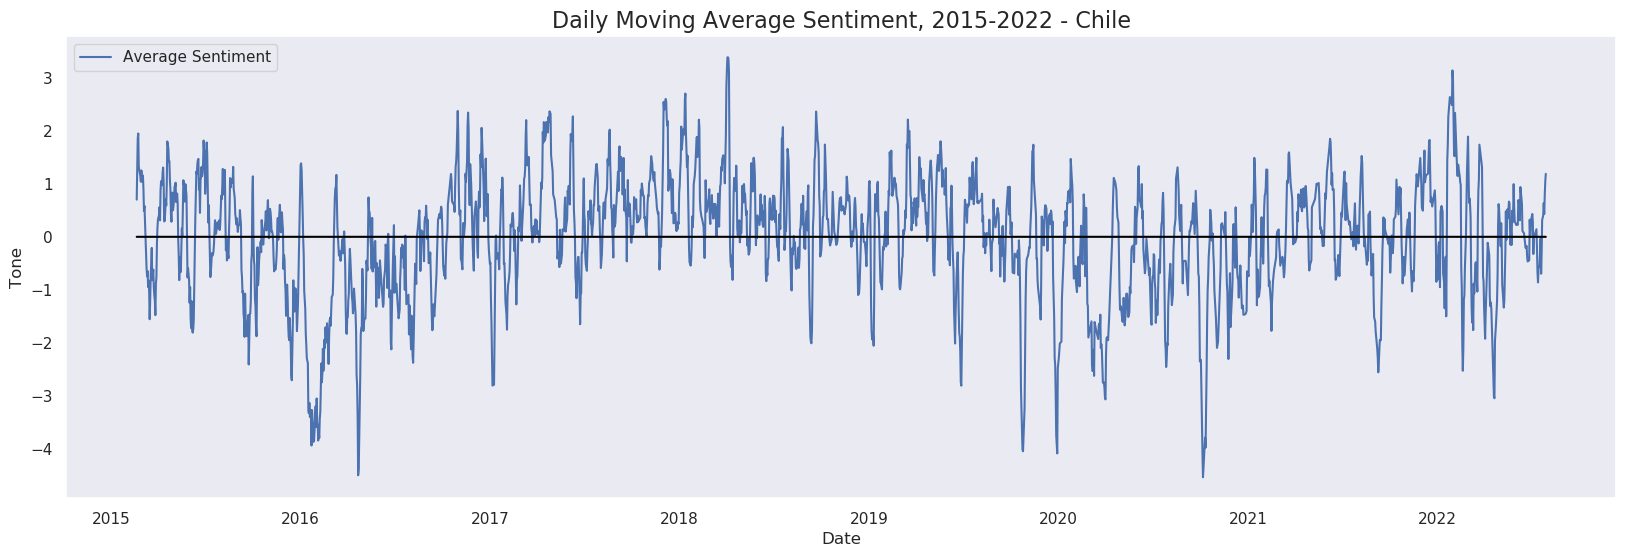

Time Period: Daily, Location:Rapa Nui
Task#24_PeruChile/Daily already exists.
PLOT: Period: Daily, Location: Rapa Nui, AvgType: rolling
Rolling plotted


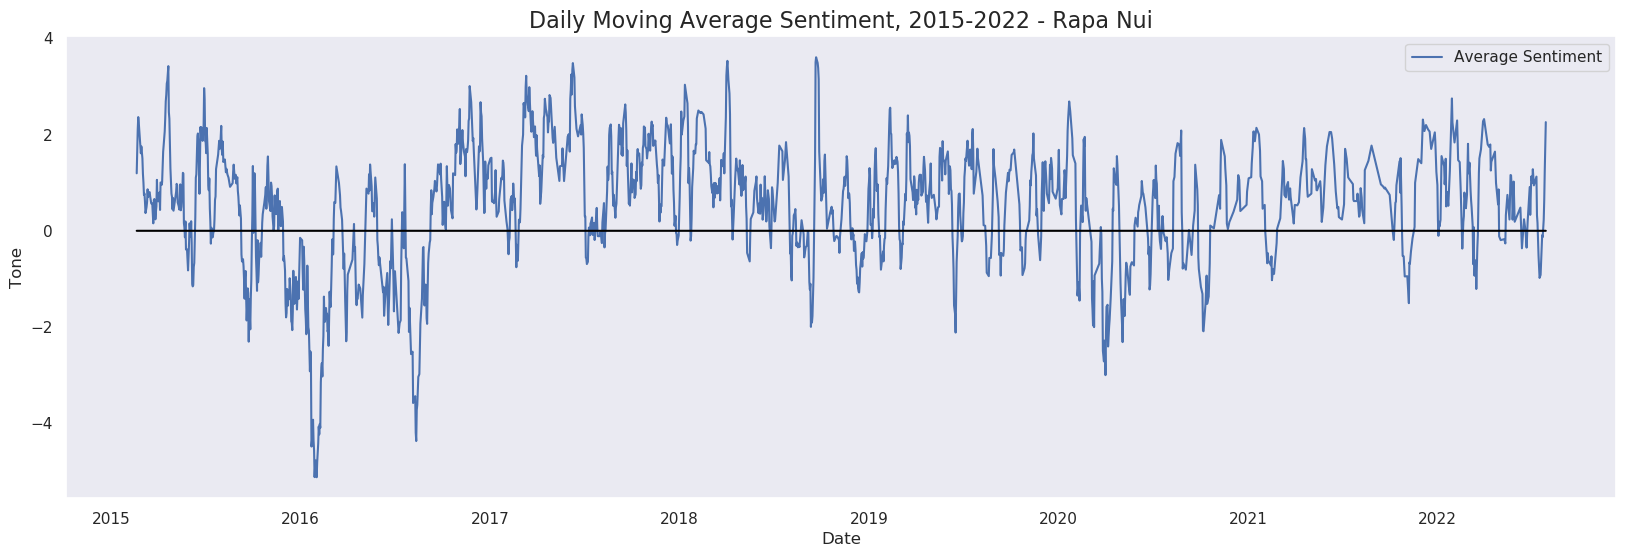

Time Period: Monthly, Location:Peru
Task#24_PeruChile/Monthly already exists.
PLOT: Period: Monthly, Location: Peru, AvgType: None


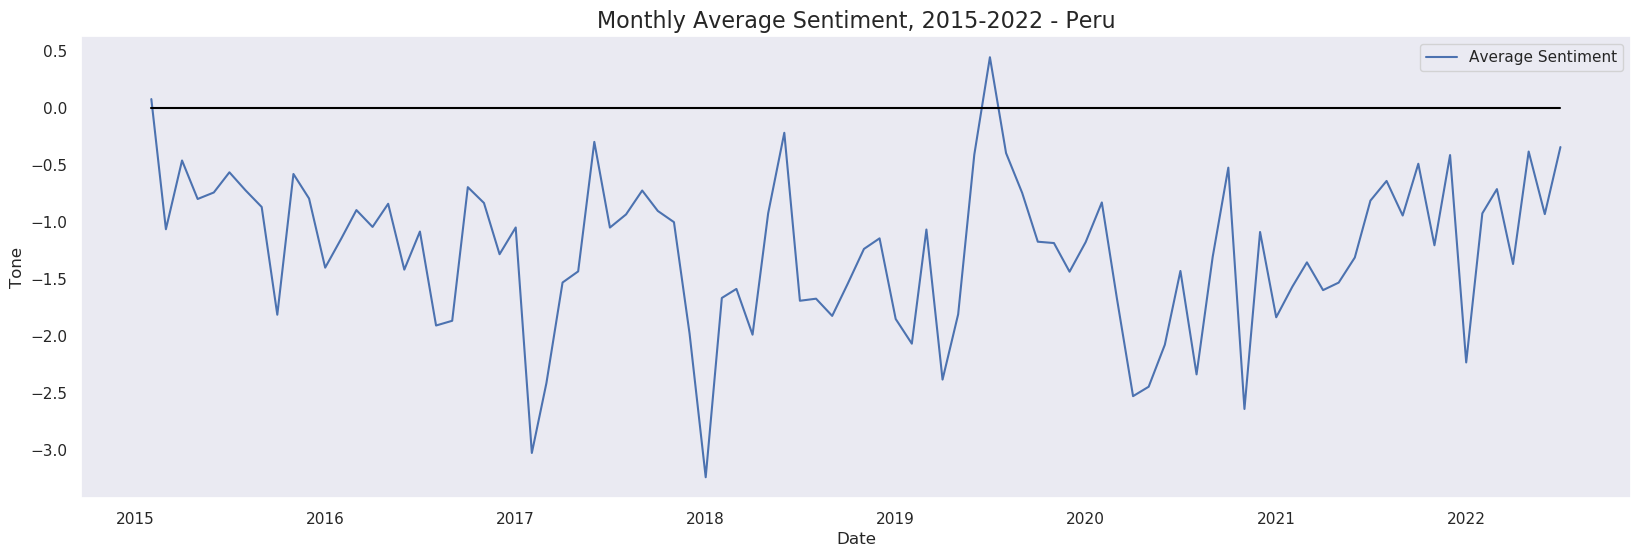

Time Period: Monthly, Location:Cuzco
Task#24_PeruChile/Monthly already exists.
PLOT: Period: Monthly, Location: Cuzco, AvgType: None


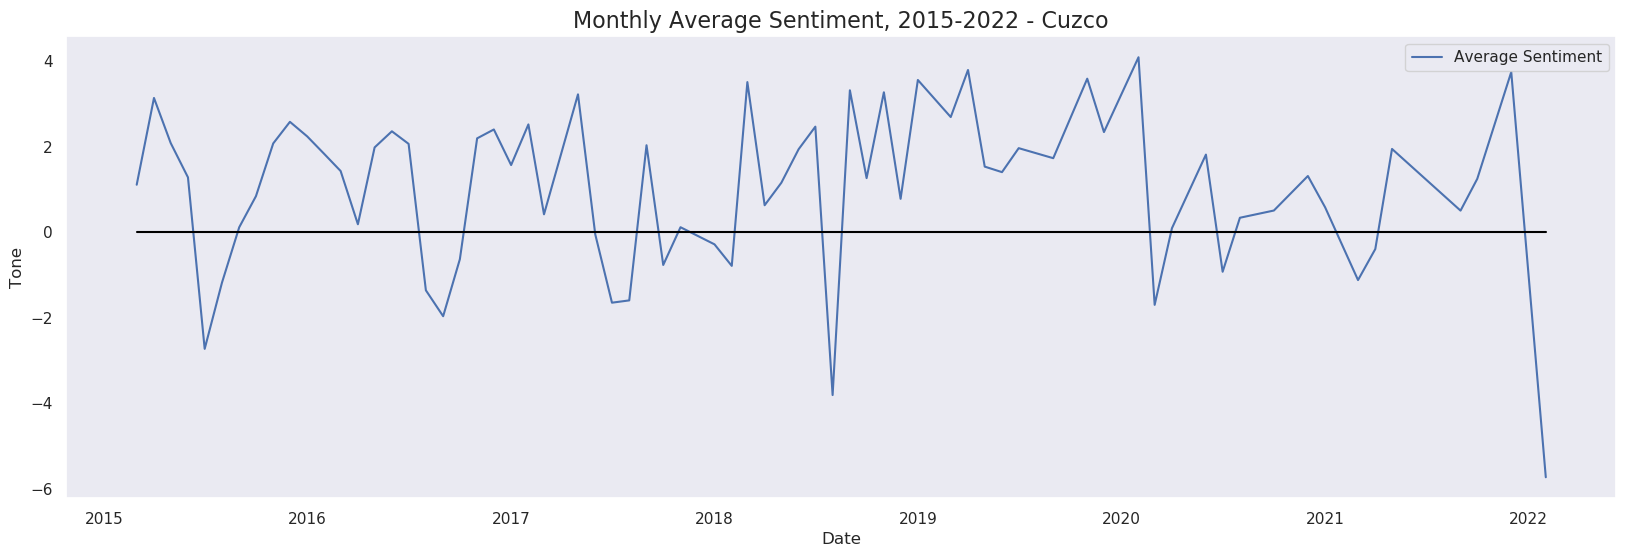

Time Period: Monthly, Location:Lima
Task#24_PeruChile/Monthly already exists.
PLOT: Period: Monthly, Location: Lima, AvgType: None


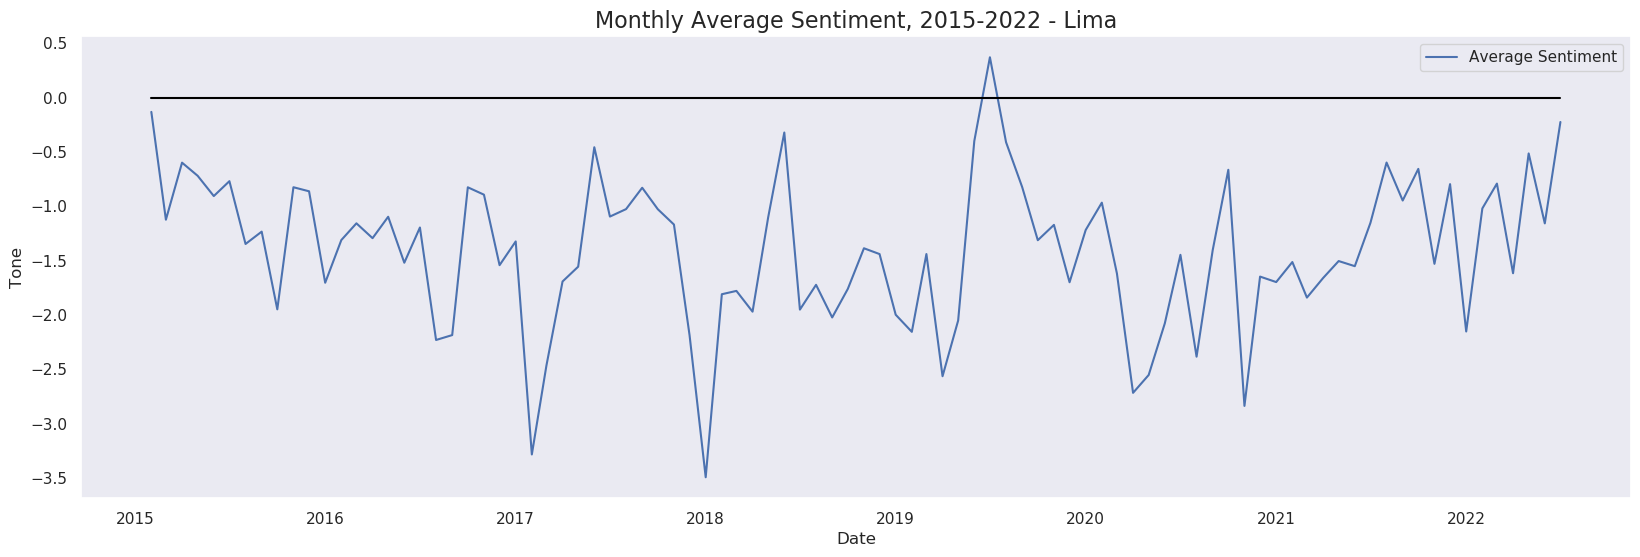

Time Period: Monthly, Location:Chan Chan
Task#24_PeruChile/Monthly already exists.
PLOT: Period: Monthly, Location: Chan Chan, AvgType: None


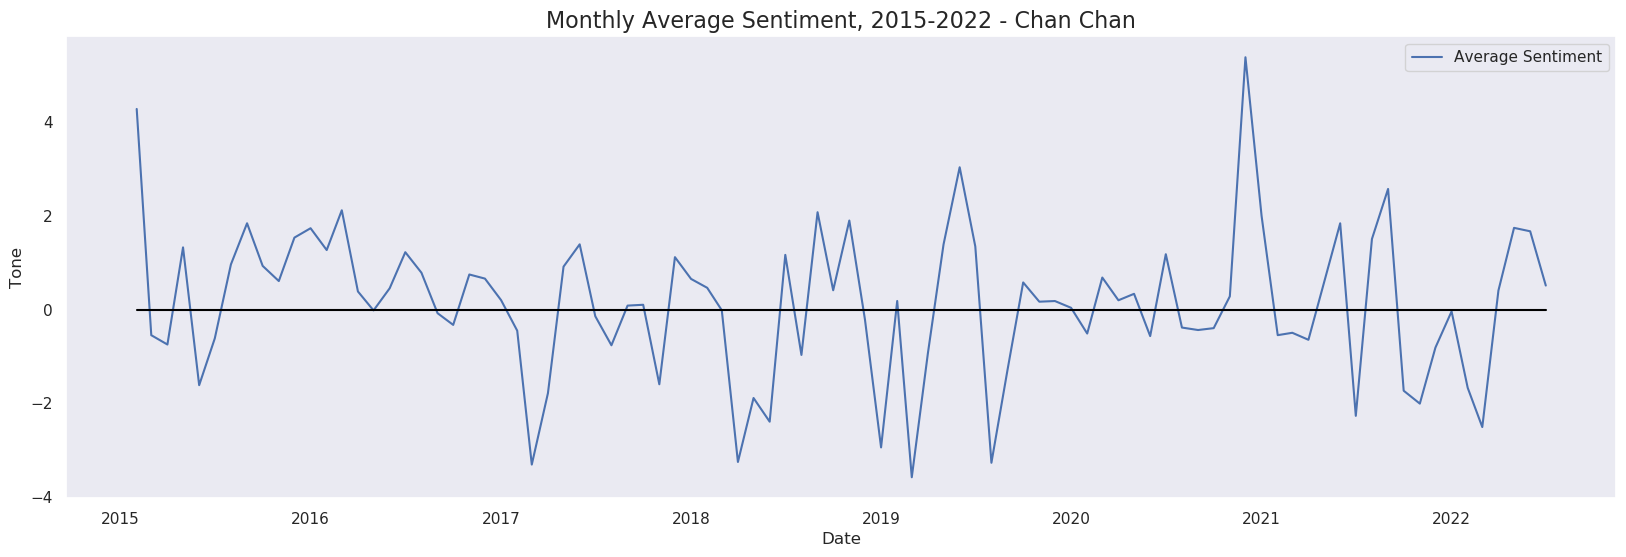

Time Period: Monthly, Location:Chile
Task#24_PeruChile/Monthly already exists.
PLOT: Period: Monthly, Location: Chile, AvgType: None


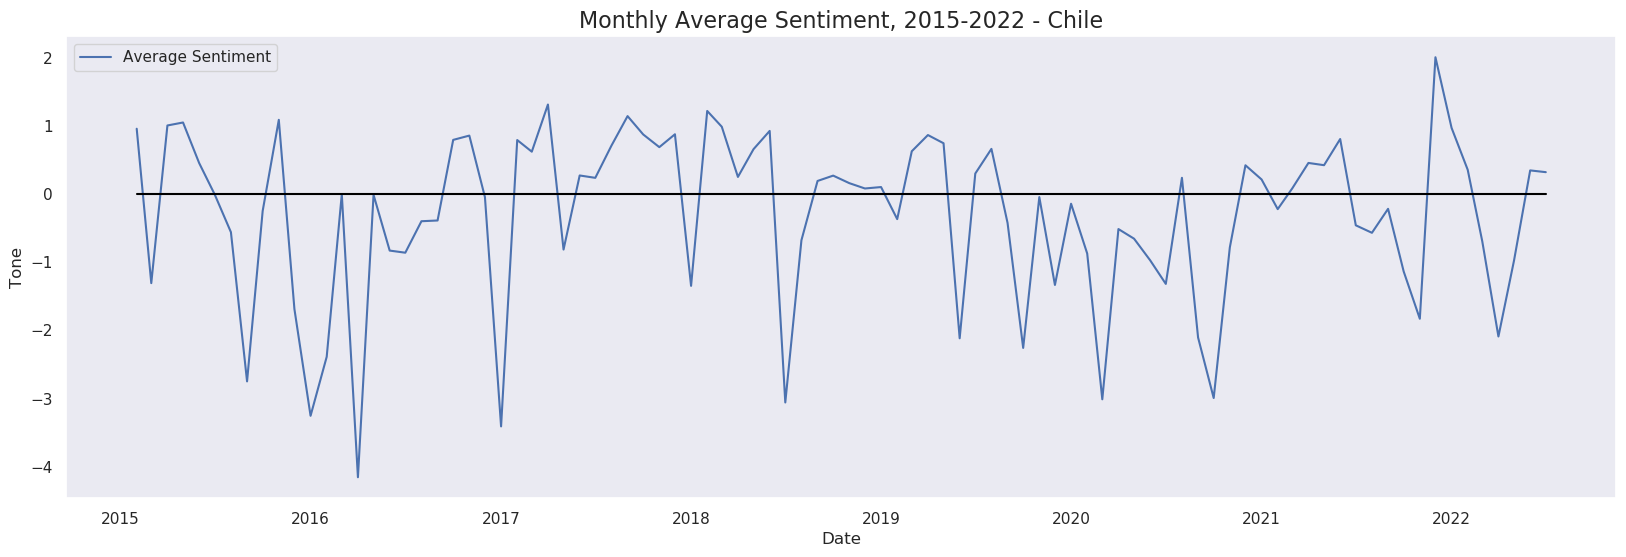

Time Period: Monthly, Location:Rapa Nui
Task#24_PeruChile/Monthly already exists.
PLOT: Period: Monthly, Location: Rapa Nui, AvgType: None


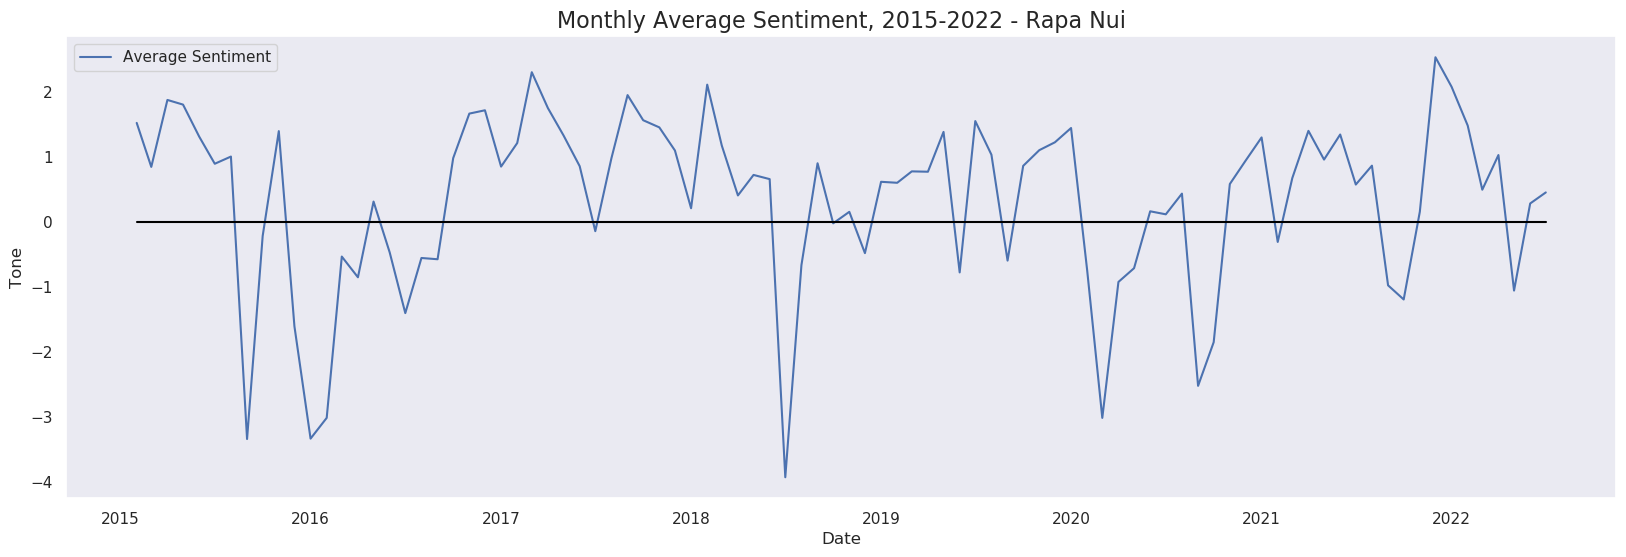

In [93]:
time_periods = ["Daily",'Monthly']
time_period = time_periods[1]
save_dir = "Task#24_PeruChile"
try: os.mkdir(save_dir)
except: print("{} already exists.".format(save_dir))
for time_period in time_periods:
    
    if time_period == "Daily": avg_type = "rolling"
    else: avg_type = None

    for country,location_name in list(country_prio_map.keys()):
        print("Time Period: {}, Location:{}".format(time_period, location_name))
        path_area = location_name.replace(" ","")
        location_path = f"{country}_{path_area}"

        path = f"s3://shrivats-dev/Tasks/#24_PeruChileGraphs/{time_period}/{location_path}/AllYears/*.csv"
        df_all = pd.read_csv(path)
        df_all['zero'] = 0

        if time_period == "Monthly":
            df_all['day'] = 1
            
        df_all['date'] = pd.to_datetime(df_all[["year","month","day"]])
        df_tone = df_all.sort_values("date").reset_index(drop = True)

        plot_tone(df_tone, save_dir = save_dir, time_period = time_period,   location_name = location_name, avg_type = avg_type)
    
  





----

In [94]:
import shutil


In [ ]:
for grid in locations:
    location_name = locations[grid]
    if grid > 0:
        save_dir = str(grid) + "_" + location_name.replace(" ","")
    else:
        save_dir = location_name.replace(" ","")
        
    shutil.make_archive(save_dir+"_compressed", 'zip', save_dir)

In [95]:
shutil.make_archive("#24_compressed",'zip',save_dir)

'/root/PrioGridTasks/WorldHeritageSites/#24_compressed.zip'